***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- Applying top-down approach. (Coarse-to-Fine)
- Changing the Secondary Capsule Dimension:
    - 8D>12D>16D (Coarse>Medium>FINE)
    - Just use Hinge Loss (MarginLoss) for each level.
    

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD\Training_and_Analysis\3_CIFAR-10
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "4" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  4
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## log directory

In [4]:
directory = sysenv.log_dir('MOD_1/3_CIFAR_10/HD_CapsNet/Mod_1_4')

FOLDER CREATED =  ../../logs/MOD_1/3_CIFAR_10/HD_CapsNet/TD_WO_C_loss


# Import Dataset : CIFAR-10

In [5]:
dataset = datasets.CIFAR10(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR10(version = 'reduce') # importing CIFAR10 Dataset

CIFAR-10 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [6]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [9]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")
    return total_marginloss

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F):
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*margin_loss(y_true_m, y_pred_m)
    ML_f = LW_F*margin_loss(y_true_f, y_pred_f)
    batch_loss = ML_c + ML_m+ ML_f
    return tf.reduce_mean(batch_loss)

## Model Architecture

In [10]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = 2
    no_medium_class = 7
    no_fine_class = 10

    PCap_n_dims = 8

    SCap_f_dims = 16
    SCap_m_dims = 12
    SCap_c_dims = 8


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    # input [batch_size, 6, 6, 512], output [batch_size, 2304, 8]
    reshapec = keras.layers.Reshape((256, PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(p_caps)

    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(s_caps_c)
    
    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(s_caps_m)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')
    
    keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [11]:
model = get_compiled_model()

In [12]:
model.summary()

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.math.subtract_3 (TFOpLambda  (None, 7)           0           ['prediction_medium[0][0]']      
 )                                                                                                
                                                                                                  
 tf.math.subtract_4 (TFOpLambda  (None, 7)           0           ['prediction_medium[0][0]']      
 )                                                                                                
                                                                                                  
 tf.math.maximum (TFOpLambda)   (None, 2)            0           ['tf.math.subtract[0][0]']       
                                                                                                  
 tf.math.subtract_2 (TFOpLambda  (None, 2)           0           ['input_yc[0][0]']               
 )        

 da)                                                                                              
                                                                                                  
 tf.math.add_2 (TFOpLambda)     (None, 10)           0           ['tf.math.multiply_8[0][0]',     
                                                                  'tf.math.multiply_10[0][0]']    
                                                                                                  
 tf.math.multiply_3 (TFOpLambda  (None,)             0           ['tf.math.reduce_sum[0][0]']     
 )                                                                                                
                                                                                                  
 tf.math.multiply_7 (TFOpLambda  (None,)             0           ['tf.math.reduce_sum_1[0][0]']   
 )                                                                                                
          

## Data Augmentation

In [13]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [14]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [15]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.3726 - prediction_coarse_accuracy: 0.8262 - prediction_medium_accuracy: 0.3337 - prediction_fine_accuracy: 0.1572
  • Coarse Accuracy = 82.62% | Val_Accuracy = 88.40% | LossWeight = 0.16 
  • Medium Accuracy = 33.37% | Val_Accuracy = 39.07% | LossWeight = 0.43 
  • Fine   Accuracy = 15.72% | Val_Accuracy = 22.84% | LossWeight = 0.41 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.22840, saving model to ../../logs/MOD_1/3_CIFAR_10/HD_CapsNet/TD_WO_C_loss\epoch-best.h5
781/781 [==============================] - 49s 54ms/step - loss: 0.3726 - prediction_coarse_accuracy: 0.8262 - prediction_medium_accuracy: 0.3337 - prediction_fine_accuracy: 0.1572 - val_loss: 0.2797 - val_prediction_coarse_accuracy: 0.8840 - val_prediction_medium_accuracy: 0.3907 - val_prediction_fine_accuracy: 0.2284 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.2318 - prediction_coarse_accurac

Epoch 18/100
781/781 [==============================] - ETA: 0s - loss: 0.0739 - prediction_coarse_accuracy: 0.9754 - prediction_medium_accuracy: 0.9246 - prediction_fine_accuracy: 0.8869
  • Coarse Accuracy = 97.54% | Val_Accuracy = 97.90% | LossWeight = 0.18 
  • Medium Accuracy = 92.46% | Val_Accuracy = 89.93% | LossWeight = 0.39 
  • Fine   Accuracy = 88.69% | Val_Accuracy = 85.67% | LossWeight = 0.43 

Epoch 18: val_prediction_fine_accuracy improved from 0.85440 to 0.85670, saving model to ../../logs/MOD_1/3_CIFAR_10/HD_CapsNet/TD_WO_C_loss\epoch-best.h5
781/781 [==============================] - 41s 52ms/step - loss: 0.0739 - prediction_coarse_accuracy: 0.9754 - prediction_medium_accuracy: 0.9246 - prediction_fine_accuracy: 0.8869 - val_loss: 0.0518 - val_prediction_coarse_accuracy: 0.9790 - val_prediction_medium_accuracy: 0.8993 - val_prediction_fine_accuracy: 0.8567 - lr: 6.6342e-04
Epoch 19/100
781/781 [==============================] - ETA: 0s - loss: 0.0719 - prediction_coar

Epoch 27/100
781/781 [==============================] - ETA: 0s - loss: 0.0631 - prediction_coarse_accuracy: 0.9812 - prediction_medium_accuracy: 0.9482 - prediction_fine_accuracy: 0.9264
  • Coarse Accuracy = 98.12% | Val_Accuracy = 98.32% | LossWeight = 0.20 
  • Medium Accuracy = 94.82% | Val_Accuracy = 91.11% | LossWeight = 0.39 
  • Fine   Accuracy = 92.64% | Val_Accuracy = 87.52% | LossWeight = 0.41 

Epoch 27: val_prediction_fine_accuracy did not improve from 0.87860
781/781 [==============================] - 40s 52ms/step - loss: 0.0631 - prediction_coarse_accuracy: 0.9812 - prediction_medium_accuracy: 0.9482 - prediction_fine_accuracy: 0.9264 - val_loss: 0.0461 - val_prediction_coarse_accuracy: 0.9832 - val_prediction_medium_accuracy: 0.9111 - val_prediction_fine_accuracy: 0.8752 - lr: 4.1812e-04
Epoch 28/100
781/781 [==============================] - ETA: 0s - loss: 0.0632 - prediction_coarse_accuracy: 0.9800 - prediction_medium_accuracy: 0.9497 - prediction_fine_accuracy: 0.

781/781 [==============================] - 40s 52ms/step - loss: 0.0597 - prediction_coarse_accuracy: 0.9818 - prediction_medium_accuracy: 0.9564 - prediction_fine_accuracy: 0.9419 - val_loss: 0.0411 - val_prediction_coarse_accuracy: 0.9846 - val_prediction_medium_accuracy: 0.9227 - val_prediction_fine_accuracy: 0.8848 - lr: 2.6352e-04
Epoch 37/100
780/781 [============================>.] - ETA: 0s - loss: 0.0597 - prediction_coarse_accuracy: 0.9825 - prediction_medium_accuracy: 0.9564 - prediction_fine_accuracy: 0.9429
  • Coarse Accuracy = 98.25% | Val_Accuracy = 98.43% | LossWeight = 0.22 
  • Medium Accuracy = 95.64% | Val_Accuracy = 92.23% | LossWeight = 0.39 
  • Fine   Accuracy = 94.29% | Val_Accuracy = 88.58% | LossWeight = 0.39 

Epoch 37: val_prediction_fine_accuracy did not improve from 0.88820
781/781 [==============================] - 40s 52ms/step - loss: 0.0597 - prediction_coarse_accuracy: 0.9825 - prediction_medium_accuracy: 0.9564 - prediction_fine_accuracy: 0.9429 - 

Epoch 55/100
781/781 [==============================] - ETA: 0s - loss: 0.0567 - prediction_coarse_accuracy: 0.9838 - prediction_medium_accuracy: 0.9628 - prediction_fine_accuracy: 0.9537
  • Coarse Accuracy = 98.38% | Val_Accuracy = 98.47% | LossWeight = 0.24 
  • Medium Accuracy = 96.28% | Val_Accuracy = 92.44% | LossWeight = 0.39 
  • Fine   Accuracy = 95.37% | Val_Accuracy = 89.10% | LossWeight = 0.37 

Epoch 55: val_prediction_fine_accuracy did not improve from 0.89410
781/781 [==============================] - 41s 52ms/step - loss: 0.0567 - prediction_coarse_accuracy: 0.9838 - prediction_medium_accuracy: 0.9628 - prediction_fine_accuracy: 0.9537 - val_loss: 0.0402 - val_prediction_coarse_accuracy: 0.9847 - val_prediction_medium_accuracy: 0.9244 - val_prediction_fine_accuracy: 0.8910 - lr: 9.9440e-05
Epoch 56/100
781/781 [==============================] - ETA: 0s - loss: 0.0560 - prediction_coarse_accuracy: 0.9840 - prediction_medium_accuracy: 0.9619 - prediction_fine_accuracy: 0.

781/781 [==============================] - 41s 53ms/step - loss: 0.0557 - prediction_coarse_accuracy: 0.9848 - prediction_medium_accuracy: 0.9645 - prediction_fine_accuracy: 0.9561 - val_loss: 0.0390 - val_prediction_coarse_accuracy: 0.9857 - val_prediction_medium_accuracy: 0.9287 - val_prediction_fine_accuracy: 0.8943 - lr: 6.2672e-05
Epoch 65/100
781/781 [==============================] - ETA: 0s - loss: 0.0559 - prediction_coarse_accuracy: 0.9847 - prediction_medium_accuracy: 0.9632 - prediction_fine_accuracy: 0.9553
  • Coarse Accuracy = 98.47% | Val_Accuracy = 98.51% | LossWeight = 0.24 
  • Medium Accuracy = 96.32% | Val_Accuracy = 92.81% | LossWeight = 0.40 
  • Fine   Accuracy = 95.53% | Val_Accuracy = 89.58% | LossWeight = 0.36 

Epoch 65: val_prediction_fine_accuracy did not improve from 0.89640
781/781 [==============================] - 41s 53ms/step - loss: 0.0559 - prediction_coarse_accuracy: 0.9847 - prediction_medium_accuracy: 0.9632 - prediction_fine_accuracy: 0.9553 - 

781/781 [==============================] - 46s 59ms/step - loss: 0.0555 - prediction_coarse_accuracy: 0.9849 - prediction_medium_accuracy: 0.9660 - prediction_fine_accuracy: 0.9594 - val_loss: 0.0385 - val_prediction_coarse_accuracy: 0.9859 - val_prediction_medium_accuracy: 0.9291 - val_prediction_fine_accuracy: 0.8964 - lr: 2.3650e-05
Epoch 84/100
781/781 [==============================] - ETA: 0s - loss: 0.0559 - prediction_coarse_accuracy: 0.9833 - prediction_medium_accuracy: 0.9637 - prediction_fine_accuracy: 0.9560
  • Coarse Accuracy = 98.33% | Val_Accuracy = 98.58% | LossWeight = 0.26 
  • Medium Accuracy = 96.37% | Val_Accuracy = 92.94% | LossWeight = 0.39 
  • Fine   Accuracy = 95.60% | Val_Accuracy = 89.65% | LossWeight = 0.35 

Epoch 84: val_prediction_fine_accuracy did not improve from 0.89770
781/781 [==============================] - 46s 59ms/step - loss: 0.0559 - prediction_coarse_accuracy: 0.9833 - prediction_medium_accuracy: 0.9637 - prediction_fine_accuracy: 0.9560 - 

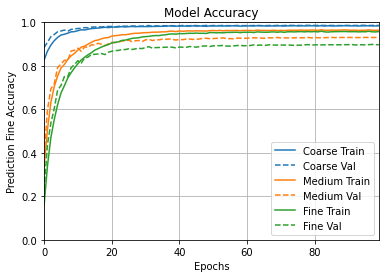

In [16]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

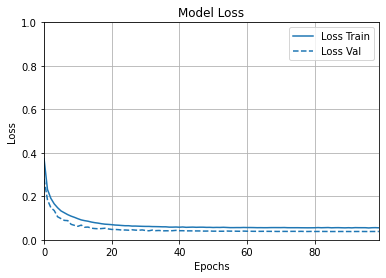

In [17]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

## Model Analysis

In [18]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 6s 14ms/step - loss: 0.0520 - prediction_coarse_loss: 0.0120 - prediction_medium_loss: 0.0529 - prediction_fine_loss: 0.0784 - prediction_coarse_accuracy: 0.9862 - prediction_medium_accuracy: 0.9301 - prediction_fine_accuracy: 0.8967
1. loss ==> 0.051981572061777115
2. prediction_coarse_loss ==> 0.012026164680719376
3. prediction_medium_loss ==> 0.05285369232296944
4. prediction_fine_loss ==> 0.07838436961174011
5. prediction_coarse_accuracy ==> 0.9861999750137329
6. prediction_medium_accuracy ==> 0.9301000237464905
7. prediction_fine_accuracy ==> 0.8967000246047974
313/313 [==============================] - 4s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

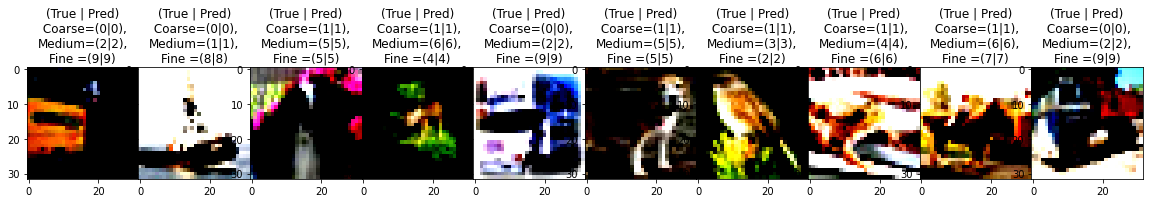

In [19]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[3945   55]
 [  83 5917]]

  • MEDIUM LEVEL 
[[ 922   21   22   18    3    6    8]
 [  27  934   27    4    4    1    3]
 [  10    5 1982    0    0    0    3]
 [  24    2    4  865   28   54   23]
 [   3    1    2   16  937   34    7]
 [  13    3   16   45   52 1811   60]
 [  15    4    4   33   22   72 1850]]

  • FINE LEVEL 
[[920  10  19   7   4   2   3   3  21  11]
 [  5 953   1   0   1   0   1   0   3  36]
 [ 25   1 869  27  12  22  29  10   2   3]
 [  6   2  32 791  21  92  38   8   1   9]
 [  6   1  27  28 882  12  20  19   3   2]
 [  5   2  20 122  18 807  13  10   1   2]
 [  4   0  16  22   4  10 940   2   1   1]
 [ 10   0   9  14  16  14   2 931   1   3]
 [ 29  10   4   2   0   0   3   1 936  15]
 [  6  46   1   2   1   0   0   1   5 938]]

  • Classification Report 


  • COARSE LEVEL 


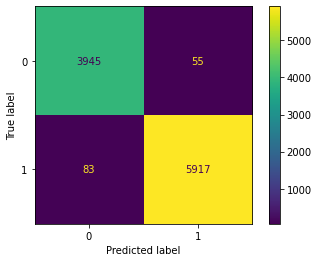

              precision    recall  f1-score   support

           0    0.97939   0.98625   0.98281      4000
           1    0.99079   0.98617   0.98847      6000

    accuracy                        0.98620     10000
   macro avg    0.98509   0.98621   0.98564     10000
weighted avg    0.98623   0.98620   0.98621     10000


  • MEDIUM LEVEL 


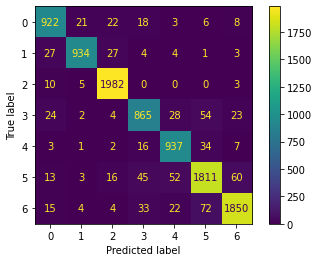

              precision    recall  f1-score   support

           0    0.90927   0.92200   0.91559      1000
           1    0.96289   0.93400   0.94822      1000
           2    0.96354   0.99100   0.97708      2000
           3    0.88175   0.86500   0.87330      1000
           4    0.89579   0.93700   0.91593      1000
           5    0.91557   0.90550   0.91051      2000
           6    0.94678   0.92500   0.93576      2000

    accuracy                        0.93010     10000
   macro avg    0.92508   0.92564   0.92520     10000
weighted avg    0.93015   0.93010   0.92997     10000


  • FINE LEVEL 


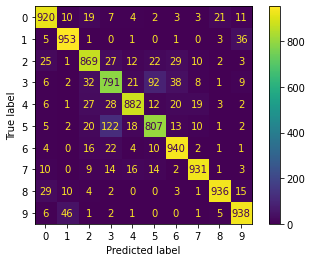

              precision    recall  f1-score   support

           0    0.90551   0.92000   0.91270      1000
           1    0.92976   0.95300   0.94123      1000
           2    0.87074   0.86900   0.86987      1000
           3    0.77931   0.79100   0.78511      1000
           4    0.91971   0.88200   0.90046      1000
           5    0.84150   0.80700   0.82389      1000
           6    0.89609   0.94000   0.91752      1000
           7    0.94518   0.93100   0.93804      1000
           8    0.96099   0.93600   0.94833      1000
           9    0.91961   0.93800   0.92871      1000

    accuracy                        0.89670     10000
   macro avg    0.89684   0.89670   0.89659     10000
weighted avg    0.89684   0.89670   0.89659     10000



In [20]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [21]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.9373433333333332 
Hierarchical Recall = 0.9393666666666668 
Hierarchical F1-Score = 0.9381833333333334 
Consistency =  0.9895 
Exact Match =  0.8928
